# Recommender systems

This notebook, by [felipe.alonso@bbva.com](mailto:felipe.alonso@bbva.com) 
(last version: v4. 09/02/2020)

## Table of Contents

1. [Gathering and analysing data](#load_data) 
2. [Most popular movies](#popular)
3. [Collaborative Filtering](#cf)  
4. [Latent Factor Models](#lfm)  
5. [Exercises (advanced)](#exercises)

In [1]:
import numpy as np
import pandas as pd
import datetime

import matplotlib.pyplot as plt
%matplotlib inline

---

<a id='load_data'></a>
# 1. Load data

We will use one the [MovieLens datasets](https://grouplens.org/datasets/movielens/), which consitutes one of the most common datasets for implementing and testing recommender engines. Specifically, we will be using the [Lastest Dataset](https://grouplens.org/datasets/movielens/latest/) (Small). This data set consists of:

* **100836 ratings** across **9742 movies**. 
* Ratings are made on a 5-star scale, with half-star increments (0.5 stars - 5.0 stars).
* TThese data were created by **610 users** between March 29, 1996 and September 24, 2018. This dataset was generated on September 26, 2018.
* Users were selected at random for inclusion. All selected **users had rated at least 20 movies**. No demographic information is included. Each user is represented by an id, and no other information is provided.
* The data are contained in the files `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`. 
* Only movies with at least one rating or tag are included in the dataset. 

For further information read the [README file](http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html).

## 1.1 Load ratings

<div class  = "alert alert-info"> 
Read the file <b>ratings.csv</b> and save it into a pandas Dataframe. Data is in the path './data/ml-latest-small/' 
</div>

In [2]:
data_path = './data/ml-latest-small/'

# Hint: pandas read_csv function might be useful

df = pd.read_csv(data_path + 'ratings.csv',sep=',', decimal='.') # YOUR CODE HERE

# we add a new colum, year, containing the year of the timestamp
df['year'] = df.timestamp.apply(lambda x: datetime.datetime.fromtimestamp(x).strftime('%Y'))

df.head()

,userId,movieId,rating,timestamp,year
0,1,1,4.0,964982703,2000
1,1,3,4.0,964981247,2000
2,1,6,4.0,964982224,2000
3,1,47,5.0,964983815,2000
4,1,50,5.0,964982931,2000


In [3]:
n_users = df.userId.unique().shape[0]
n_movies = df.movieId.unique().shape[0]
print('#ratings =', df.shape[0])
print('#users = ' + str(n_users) + '\n#movies = ' + str(n_movies))

#ratings = 100836
#users = 610
#movies = 9724


### 1.1.1 Ratings analytics

Let's go deeper into our data, trying to answer questions like:

1. Which is the average rating for all movies? 
2. And the distribution of ratings? 
3. And the average rating by time (years)?
4. And the average number of rated movies per user? 
5. And the distribution of rated movies per user?

<div class  = "alert alert-info"> 
<b> QUESTION </b>: Show (you can do some drawings if you want) some statistics to understand your data
</div>

Avg. rating : 3.501556983616962


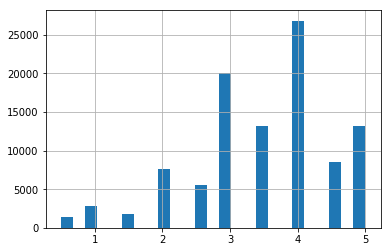

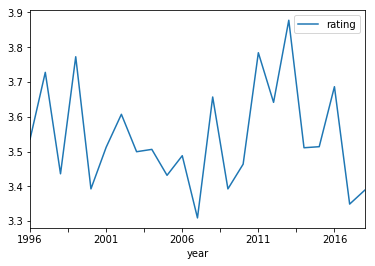

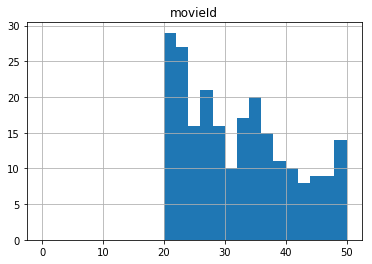

In [4]:
# Let's give some metrics

# 1) Average rating for all times
avg_rating = df.rating.mean() # YOUR CODE HERE
print('Avg. rating :', avg_rating)

# 2) Rating distribution
df.rating.hist(bins=25) # YOUR CODE HERE
plt.show()

# 3) Average rating by time
df[['rating','year']].groupby('year').mean().plot() # YOUR CODE HERE
plt.show()

# 4) Average number of rated movies per user
df[['userId','movieId']].groupby('userId').count().hist(bins=25, range=(0,50))
plt.show()
# option 2: plt.hist(np.unique(df.userId,return_counts=True)[1])

## 1.2 Load movies

In [5]:
movies = pd.read_csv(data_path + 'movies.csv',sep=',')
#movies = movies.set_index('movieId')

print('Number of rows: ', movies.shape[0])
print('Number of (unique) movies: ',len(movies.movieId.unique()))
movies.tail()

Number of rows:  9742
Number of (unique) movies:  9742


,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


### 1.2.1 Duplicated movieId

Unfortunately, the dataset is not completely clear. **There are a few movies with several `ids`**. Let's find them out

In [6]:
n_movies_per_id = movies[['movieId','title']].groupby('title').count().sort_values('movieId',ascending=False)
n_movies_per_id.columns = ['n_ids']
n_movies_per_id = n_movies_per_id[n_movies_per_id.n_ids>1]

movieId_to_remove = []
for t in n_movies_per_id.index.values:
    print('The movie:',t,', has these ids: ', movies.loc[movies.title == t].movieId.values)
    movieId_to_remove.append(movies.loc[movies.title == t].movieId.values[-1])

print("\nWe have to remove these indexes values: ", movieId_to_remove)

The movie: Confessions of a Dangerous Mind (2002) , has these ids:  [  6003 144606]
The movie: Emma (1996) , has these ids:  [  838 26958]
The movie: Eros (2004) , has these ids:  [ 32600 147002]
The movie: War of the Worlds (2005) , has these ids:  [34048 64997]
The movie: Saturn 3 (1980) , has these ids:  [  2851 168358]

We have to remove these indexes values:  [144606, 26958, 147002, 64997, 168358]


So we remove the `movies.title` duplicates

In [7]:
movies = movies.drop_duplicates(subset=['title'],keep='first')

print(movies.shape)
movies.tail()

(9737, 3)


,movieId,title,genres
9737,193581,Black Butler: Book of the Atlantic (2017),Action|Animation|Comedy|Fantasy
9738,193583,No Game No Life: Zero (2017),Animation|Comedy|Fantasy
9739,193585,Flint (2017),Drama
9740,193587,Bungo Stray Dogs: Dead Apple (2018),Action|Animation
9741,193609,Andrew Dice Clay: Dice Rules (1991),Comedy


We should remove also all entries in ratings data where `movieId == movieId_to_remov` (note that there would be other possibilities like changing the `movieId` in ratings data)

In [8]:
df = df[~df.movieId.isin(movieId_to_remove)]

n_users = df.userId.unique().shape[0]
n_items = df.movieId.unique().shape[0]
print('Number of users = ' + str(n_users) + ' | Number of movies = ' + str(n_items)  )

Number of users = 610 | Number of movies = 9719


### 1.2.2 Not rated movies

As you can see, there are **9722 rated movies** (`ratings.csv`), while there are **9737 distinct movies** in the database (`movies.csv`). Let's find the list of movies that have not been rated

In [9]:
ratedMovieIds = df.movieId.unique()
notRatedMoviesTitles = movies.loc[~movies.movieId.isin(ratedMovieIds),['movieId','title']]

print('There are', len(notRatedMoviesTitles), 'movies with no rating, which are:\n')
print('movieId\t title')
print(notRatedMoviesTitles.values)

There are 18 movies with no rating, which are:

movieId	 title
[[1076 'Innocents, The (1961)']
 [2939 'Niagara (1953)']
 [3338 'For All Mankind (1989)']
 [3456 'Color of Paradise, The (Rang-e khoda) (1999)']
 [4194 "I Know Where I'm Going! (1945)"]
 [5721 'Chosen, The (1981)']
 [6668 'Road Home, The (Wo de fu qin mu qin) (1999)']
 [6849 'Scrooge (1970)']
 [7020 'Proof (1991)']
 [7792 'Parallax View, The (1974)']
 [8765 'This Gun for Hire (1942)']
 [25855 'Roaring Twenties, The (1939)']
 [26085 'Mutiny on the Bounty (1962)']
 [30892 'In the Realms of the Unreal (2004)']
 [32160 'Twentieth Century (1934)']
 [32371 'Call Northside 777 (1948)']
 [34482 'Browning Version, The (1951)']
 [85565 'Chalet Girl (2011)']]


## 1.3 reindexing users and movies


#### Movies Ids

Let's move forward. In order to analyze the predicted recommendations, let's create a python dictonary for translating `movieId` to movie titles, and `movieId` to an integer id (`idx`). This way `idx` will vary between 0 and 9137-1 (movies in `movies.csv`).

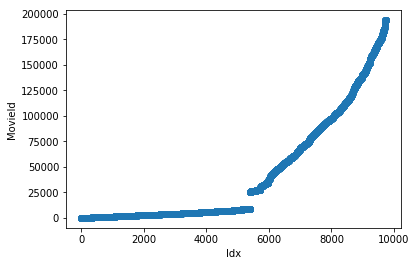

In [10]:
movies_id_list = np.unique(movies.movieId.values)

# MovieId to idx
movieId_to_idx = {movieId:idx for idx, movieId in enumerate(movies_id_list)}
movies['movieIdx'] = movies['movieId'].apply(lambda x: movieId_to_idx[x])

plt.scatter(movies.movieIdx,movies.movieId)
plt.xlabel('Idx')
plt.ylabel('MovieId')
plt.show()

In [15]:
# See the result
movies.head()

,movieId,title,genres,movieIdx
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,0
1,2,Jumanji (1995),Adventure|Children|Fantasy,1
2,3,Grumpier Old Men (1995),Comedy|Romance,2
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance,3
4,5,Father of the Bride Part II (1995),Comedy,4


#### Modify `ratings` to include new information

In [12]:
idx_to_title = {idx:title for idx,title in zip(movies.movieIdx.values,movies.title.values)}

df['movieIdx'] = df['movieId'].apply(lambda x: movieId_to_idx[x])
df['title'] = df['movieIdx'].apply(lambda x: idx_to_title[x])

df.head()

,userId,movieId,rating,timestamp,year,movieIdx,title
0,1,1,4.0,964982703,2000,0,Toy Story (1995)
1,1,3,4.0,964981247,2000,2,Grumpier Old Men (1995)
2,1,6,4.0,964982224,2000,5,Heat (1995)
3,1,47,5.0,964983815,2000,43,Seven (a.k.a. Se7en) (1995)
4,1,50,5.0,964982931,2000,46,"Usual Suspects, The (1995)"


As we can see, `year` does not represent the year of release. Let's calculate it

In [13]:
import re

def extract_year(title):
    
    p = re.compile(r"(?:\((\d{4})\))?\s*$")
    m = p.search(title)
    year = m.group(1)
    
    return year

df['year_release'] = df.title.apply(lambda x:extract_year(x))
df.head()

,userId,movieId,rating,timestamp,year,movieIdx,title,year_release
0,1,1,4.0,964982703,2000,0,Toy Story (1995),1995
1,1,3,4.0,964981247,2000,2,Grumpier Old Men (1995),1995
2,1,6,4.0,964982224,2000,5,Heat (1995),1995
3,1,47,5.0,964983815,2000,43,Seven (a.k.a. Se7en) (1995),1995
4,1,50,5.0,964982931,2000,46,"Usual Suspects, The (1995)",1995


In [29]:
df.tail()

,userId,movieId,rating,timestamp,year,movieIdx,title,year_release
100831,610,166534,4.0,1493848402,2017,9430,Split (2017),2017
100832,610,168248,5.0,1493850091,2017,9457,John Wick: Chapter Two (2017),2017
100833,610,168250,5.0,1494273047,2017,9458,Get Out (2017),2017
100834,610,168252,5.0,1493846352,2017,9459,Logan (2017),2017
100835,610,170875,3.0,1493846415,2017,9498,The Fate of the Furious (2017),2017


#### User Ids

User ids start from 1 to 610, and we will change it to range between 0 a 609 (they are assigned sequentially)

In [30]:
df.userId = df.userId -1
df.head()

,userId,movieId,rating,timestamp,year,movieIdx,title,year_release
0,0,1,4.0,964982703,2000,0,Toy Story (1995),1995
1,0,3,4.0,964981247,2000,2,Grumpier Old Men (1995),1995
2,0,6,4.0,964982224,2000,5,Heat (1995),1995
3,0,47,5.0,964983815,2000,43,Seven (a.k.a. Se7en) (1995),1995
4,0,50,5.0,964982931,2000,46,"Usual Suspects, The (1995)",1995


#### Retrieve Movies IDs

Define a function that retrieves all the ids and titles for movies containing 'text' in its title

In [27]:
def return_movie_id(text, ids):
    """
    Inputs:
    - text: string to be looked for in movies titles
    - ids: dictionary of {id:title}
    
    Return: 
    - A list of (id,title) if text found in titles, and an empty list otherwise.
    """
    
    return [(k, v) for k, v in list(ids.items()) if v.lower().find(text.lower()) > -1]
 

In [28]:
queryTitle = 'Star Wars'
return_movie_id(queryTitle, idx_to_title)

[(224, 'Star Wars: Episode IV - A New Hope (1977)'),
 (898, 'Star Wars: Episode V - The Empire Strikes Back (1980)'),
 (911, 'Star Wars: Episode VI - Return of the Jedi (1983)'),
 (1979, 'Star Wars: Episode I - The Phantom Menace (1999)'),
 (3832, 'Star Wars: Episode II - Attack of the Clones (2002)'),
 (5895, 'Star Wars: Episode III - Revenge of the Sith (2005)'),
 (6822, 'Star Wars: The Clone Wars (2008)'),
 (7365, "Empire of Dreams: The Story of the 'Star Wars' Trilogy (2004)"),
 (8681, 'Star Wars: Episode VII - The Force Awakens (2015)'),
 (8906, 'The Star Wars Holiday Special (1978)'),
 (9429, 'Rogue One: A Star Wars Story (2016)'),
 (9640, 'Star Wars: The Last Jedi (2017)'),
 (9705, 'Solo: A Star Wars Story (2018)')]

<div class  = "alert alert-info"> 
<b>QUESTION</b>: in the previous cell, change <tt>queryTitle</tt> to find the index of a movie of your taste. Change also <tt>idx_to_movieTitle</tt> for <tt>movieId_to_movieTitle</tt> and check out the differences.
</div>

---
<a id='popular'></a>
# 2. Most popular movies

Movies can be ranked according to different popularity metrics:
* Most rated movie (it is assumed that this is the most watched movie)
* Highest averaged rated movie

## 2.1 Most rated movie

In [37]:
most_rated_movie = df[['userId','title']].groupby(['title']).count().sort_values('userId',ascending=False)
most_rated_movie.columns = ['popularity_score']

most_rated_movie.head(10)

,popularity_score
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


## 2.2 Highest averaged rated movie

In [56]:
avg_rating_per_movie = df[['title','rating']].groupby('title').agg(['mean', 'count'])
avg_rating_per_movie.columns = ['avg_rating','n_raters']
avg_rating_per_movie.head()

min_raters = 1
avg_rating_per_movie = avg_rating_per_movie[avg_rating_per_movie.n_raters>=min_raters]
avg_rating_per_movie = avg_rating_per_movie.sort_values(['avg_rating'],ascending=False)

avg_rating_per_movie.head(10)

,avg_rating,n_raters
title,,
Tom Segura: Mostly Stories (2016),5.0,1
Winter in Prostokvashino (1984),5.0,1
The Adventures of Sherlock Holmes and Doctor Watson: The Treasures of Agra (1983),5.0,1
The Adventures of Sherlock Holmes and Dr. Watson: Bloody Signature (1979),5.0,1
When Worlds Collide (1951),5.0,1
Watching the Detectives (2007),5.0,1
Superman/Batman: Public Enemies (2009),5.0,1
"Thin Line Between Love and Hate, A (1996)",5.0,1
Supercop 2 (Project S) (Chao ji ji hua) (1993),5.0,1


<div class  = "alert alert-info"> 
<b> QUESTION </b>: Change the value of <tt>min_raters</tt> and re-run the above cell. What happens now? 
</div>

---
<a id='cf'></a>
# 3. Collaborative filtering

## 3.1 Naïve approach

*"People who watched (rated/purchased) this movie (product) also watched (rated/purchased)..."* 

Let's build our co-occurrence matrix

In [57]:
print('Number of rated movies:', len(df.movieIdx.unique()))
print('Number of movies:', len(movies.movieIdx.unique()))

Number of rated movies: 9719
Number of movies: 9737


<div class  = "alert alert-info"> 
<b> QUESTION </b>: Aiming to build a co-occurrence matrix, which should be the dimensions of this matrix? 
</div>

### 3.1.1 Build co-occurence matrix

In [81]:
# This might be useful
movies_per_user_dict = {user_id:idx.values for user_id,idx in df.groupby('userId')['movieIdx']}

# check movies_per_user_dict (uncomment the following lines if necessary)

#this_user_id = 0
#movies_per_user_dict[this_user_id]
#[idx_to_title[k] for k in movies_per_user_dict[this_user_id]] # retrieve titles 

In [84]:
N = len(movies.movieIdx.unique()) # YOUR CODE HERE 
print(N)

coMatrix = np.zeros((N, N)) # co-occurrence matrix
for userId, ids in movies_per_user_dict.items():
    for m in ids:
        coMatrix[m,ids] += 1 # YOUR CODE HERE

print(coMatrix.shape)

9737
(9737, 9737)


In [85]:
coMatrix[0:10,0:10]

array([[215.,  68.,  32.,   2.,  32.,  58.,  32.,   5.,  12.,  69.],
       [ 68., 110.,  26.,   3.,  22.,  36.,  18.,   6.,   3.,  56.],
       [ 32.,  26.,  52.,   1.,  19.,  25.,  19.,   4.,   9.,  23.],
       [  2.,   3.,   1.,   7.,   3.,   2.,   6.,   1.,   0.,   4.],
       [ 32.,  22.,  19.,   3.,  49.,  24.,  23.,   4.,   9.,  20.],
       [ 58.,  36.,  25.,   2.,  24., 102.,  22.,   5.,   9.,  49.],
       [ 32.,  18.,  19.,   6.,  23.,  22.,  54.,   4.,   5.,  22.],
       [  5.,   6.,   4.,   1.,   4.,   5.,   4.,   8.,   0.,   6.],
       [ 12.,   3.,   9.,   0.,   9.,   9.,   5.,   0.,  16.,   3.],
       [ 69.,  56.,  23.,   4.,  20.,  49.,  22.,   6.,   3., 132.]])

### 3.1.2 Predictions using the co-occurrence matrix

Now, let's make predictions!

In [86]:
queryTitle = 'lambs'
return_movie_id(queryTitle, idx_to_title)

[(510, 'Silence of the Lambs, The (1991)'), (6618, 'Lions For Lambs (2007)')]

In [110]:
queryMovieId = 510 # YOUR CODE HERE
print('Let\'s make recommendations for: ', idx_to_title[queryMovieId])
print('')

# Get the corresponding row 
queryAnswer = coMatrix[queryMovieId,:] # YOUR CODE HERE

# Get the highest counts (np.argsort might be useful, in descending order)
queryAnswer = np.argsort(queryAnswer)[::-1] # YOUR CODE HERE

# Get the highest counts (do not select the query movie)
queryAnswer = queryAnswer[1:]# YOUR CODE HERE
queryAnswer

# let's print out the first 20 recommendations
printAnswer = queryAnswer[0:20]
for i,answerId in enumerate(printAnswer):
    print(i+1,'-', idx_to_title[answerId])

Let's make recommendations for:  Silence of the Lambs, The (1991)

1 - Pulp Fiction (1994)
2 - Forrest Gump (1994)
3 - Shawshank Redemption, The (1994)
4 - Matrix, The (1999)
5 - Jurassic Park (1993)
6 - Star Wars: Episode IV - A New Hope (1977)
7 - Braveheart (1995)
8 - Seven (a.k.a. Se7en) (1995)
9 - Terminator 2: Judgment Day (1991)
10 - Schindler's List (1993)
11 - Fugitive, The (1993)
12 - American Beauty (1999)
13 - Usual Suspects, The (1995)
14 - Fight Club (1999)
15 - Star Wars: Episode V - The Empire Strikes Back (1980)
16 - Fargo (1996)
17 - Apollo 13 (1995)
18 - Batman (1989)
19 - Godfather, The (1972)
20 - Independence Day (a.k.a. ID4) (1996)


<div class  = "alert alert-info"> 
<b> QUESTION </b>: How accurate are these recommendations? Alternatives?
</div>

### 3.1.3 Jaccard similarity 

What about using the [Jaccard similarity index](https://en.wikipedia.org/wiki/Jaccard_index)?

In [111]:
i = queryMovieId
jaccardScore = np.zeros(N-1)
for j in range(N-1):
    num = coMatrix[i,j]  # YOUR CODE HERE 
    dem = coMatrix[i,i] + coMatrix[j,j] - coMatrix[i,j] # YOUR CODE HERE 
    jaccardScore[j] = float(num)/float(dem) 

queryAnswer = np.argsort(jaccardScore)[::-1] #descending order
queryAnswer = queryAnswer[1:] 

# let's print out the first 20 recommendations
printAnswer = queryAnswer[0:20]
for i,answerId in enumerate(printAnswer):
    print(i+1,'-', idx_to_title[answerId])

1 - Pulp Fiction (1994)
2 - Shawshank Redemption, The (1994)
3 - Forrest Gump (1994)
4 - Seven (a.k.a. Se7en) (1995)
5 - Jurassic Park (1993)
6 - Fugitive, The (1993)
7 - Schindler's List (1993)
8 - Terminator 2: Judgment Day (1991)
9 - Star Wars: Episode IV - A New Hope (1977)
10 - Fargo (1996)
11 - Braveheart (1995)
12 - Matrix, The (1999)
13 - American Beauty (1999)
14 - Usual Suspects, The (1995)
15 - Apollo 13 (1995)
16 - Fight Club (1999)
17 - Star Wars: Episode V - The Empire Strikes Back (1980)
18 - Batman (1989)
19 - Godfather, The (1972)
20 - True Lies (1994)


## 3.2 Memory-Based Collaborative Filtering (CF)

Memory-Based Collaborative Filtering approaches can be divided into two main sections: **user-user filtering** and **item-item filtering**. 

* User-user CF: *“Users who are similar to you also liked …”*. A *user-user filtering* will take a particular user, find users that are similar to that user based on similarity of ratings, and recommend items that those similar users liked. 

* Item-Item CF: *“Users who liked this movie also liked …”*. In contrast, *item-item filtering* will take an item, find users who liked that item, and find other items that those users or similar users also liked. 


First, we need to build our utility matrix. 

In [127]:
# just as a reminder of the information
df.head(2)

,userId,movieId,rating,timestamp,year,movieIdx,title,year_release
0,0,1,4.0,964982703,2000,0,Toy Story (1995),1995
1,0,3,4.0,964981247,2000,2,Grumpier Old Men (1995),1995


In [120]:
# build utility matrix
n_items = len(movies.movieIdx.unique()) # YOUR CODE HERE 
n_users = len(df.userId.unique())       # YOUR CODE HERE 
print(n_users, 'x', n_items)

uMatrix = np.zeros((n_users, n_items)) # utility matrix

for row in df.itertuples():
    user_id = row[1]
    item_id = row[6]
    uMatrix[user_id, item_id] = row[3] # YOUR CODE HERE 

print('Dimensions: ', uMatrix.shape)

610 x 9737
Dimensions:  (610, 9737)


#### Do some checking ...

In [126]:
# show uMatrix
print(uMatrix[0:10,0:10])

# check for an specific user
print(movies_per_user_dict[5][0:10])

[[4.  0.  4.  0.  0.  4.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [4.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  4.  5.  3.  5.  4.  4.  3.  0.  3. ]
 [4.5 0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  4.  0.  0.  0.  0.  0.  0.  0.  2. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  0. ]]
[ 1  2  3  4  5  6  7  9 10 12]


#### Cosine similarity

Now, we define our similarity function

In [128]:
def cosineSimilarity(ratings, kind='user', epsilon=1e-9):
    # epsilon -> small number for handling dived-by-zero errors
    if kind == 'user':
        sim = ratings.dot(ratings.T) + epsilon
    elif kind == 'item':
        sim = ratings.T.dot(ratings) + epsilon
    norms = np.array([np.sqrt(np.diagonal(sim))])
    return (sim / norms / norms.T)  

So we can now calculate our similarity matrices.

In [130]:
userSimilarity = cosineSimilarity(uMatrix, kind='user')
print('user-user: ', userSimilarity.shape)

itemSimilarity = cosineSimilarity(uMatrix, kind='item')
print('item-item: ', itemSimilarity.shape)

user-user:  (610, 610)
item-item:  (9737, 9737)


In [143]:
# do some checking
print(userSimilarity[0:12,0:12].round(2))
print('')
print(itemSimilarity[0:12,0:12].round(2))

[[1.   0.03 0.06 0.19 0.13 0.13 0.16 0.14 0.06 0.02 0.13 0.02]
 [0.03 1.   0.   0.   0.02 0.03 0.03 0.03 0.   0.07 0.04 0.  ]
 [0.06 0.   1.   0.   0.01 0.   0.   0.   0.   0.   0.   0.  ]
 [0.19 0.   0.   1.   0.13 0.09 0.12 0.06 0.01 0.03 0.05 0.05]
 [0.13 0.02 0.01 0.13 1.   0.3  0.11 0.43 0.   0.03 0.18 0.06]
 [0.13 0.03 0.   0.09 0.3  1.   0.08 0.37 0.01 0.02 0.22 0.1 ]
 [0.16 0.03 0.   0.12 0.11 0.08 1.   0.11 0.1  0.13 0.19 0.05]
 [0.14 0.03 0.   0.06 0.43 0.37 0.11 1.   0.   0.02 0.24 0.05]
 [0.06 0.   0.   0.01 0.   0.01 0.1  0.   1.   0.04 0.   0.  ]
 [0.02 0.07 0.   0.03 0.03 0.02 0.13 0.02 0.04 1.   0.03 0.09]
 [0.13 0.04 0.   0.05 0.18 0.22 0.19 0.24 0.   0.03 1.   0.03]
 [0.02 0.   0.   0.05 0.06 0.1  0.05 0.05 0.   0.09 0.03 1.  ]]

[[1.   0.41 0.3  0.04 0.31 0.38 0.28 0.13 0.23 0.4  0.32 0.22]
 [0.41 1.   0.28 0.11 0.29 0.3  0.23 0.17 0.04 0.42 0.32 0.17]
 [0.3  0.28 1.   0.09 0.42 0.28 0.4  0.31 0.3  0.24 0.25 0.2 ]
 [0.04 0.11 0.09 1.   0.19 0.09 0.28 0.16 0.   0.1  0

#### Find similar users

In [144]:
# run this cell
def findKsimilars(rowId,simMatrix,k=5):
    qAnswer = simMatrix[rowId,:]
    qIds = np.argsort(qAnswer)[::-1]
    qValues = simMatrix[rowId,qIds]
    
    return [(qIds[j],qValues[j]) for j in range(1,k+1)]

In [150]:
queryUser = 0
moreSimilarUsers = findKsimilars(queryUser,userSimilarity,k=5)

print('The more similar users to USER_ID =', queryUser, 'are:\n')

for u,v in moreSimilarUsers:
    print('User',u, 'with a similarity of ', v)

The more similar users to USER_ID = 0 are:

User 265 with a similarity of  0.3574077096034573
User 312 with a similarity of  0.35156151849109923
User 367 with a similarity of  0.34512705158368145
User 56 with a similarity of  0.34503427880770776
User 90 with a similarity of  0.33472692041828545


#### Find similar items

In [155]:
queryTitle = 'mallrats'
return_movie_id(queryTitle, idx_to_title)

[(152, 'Mallrats (1995)')]

In [157]:
queryMovieId = 510
moreSimilarItems = findKsimilars(queryMovieId,itemSimilarity,k=5)

print('The more similar movies to ', idx_to_title[queryMovieId], 'are:\n')

for item in moreSimilarItems:
    print(idx_to_title[item[0]], 'with a similarity of ', item[1])

The more similar movies to  Silence of the Lambs, The (1991) are:

Pulp Fiction (1994) with a similarity of  0.7093823704436711
Shawshank Redemption, The (1994) with a similarity of  0.6470657221296076
Forrest Gump (1994) with a similarity of  0.6394625289111698
Seven (a.k.a. Se7en) (1995) with a similarity of  0.6309827687041384
Fugitive, The (1993) with a similarity of  0.5943408289185073


<div class = "alert alert-success">
<b>Exercise (advanced - optional):</b> Implement centered cosine similarity metric
</div>

```python
def centeredCosineSimilarity(ratings, kind='user', epsilon=1e-9):
    # YOUR CODE HERE
```

### 3.2.1 Predictions for specific user

In [158]:
useruserCFpredictions = userSimilarity.dot(uMatrix) / np.array([np.abs(userSimilarity).sum(axis=1)]).T 

In [167]:
queryUser = 500

queryAnswer = uMatrix[queryUser,:]
queryAnswer = np.argsort(queryAnswer)[::-1] #descending order

print('User_ID: ' + str(queryUser) + ', liked the most:')
print(' ')
# let's print out the first 20 recommendations
printAnswer = queryAnswer[0:11]
for answerId in printAnswer:
    print(uMatrix[queryUser,answerId],'-',idx_to_title[answerId])
    
print('\n... and he/she has not seen ... ')

noWatchedMovies = np.where(uMatrix[queryUser,:]==0)[0]
for m in noWatchedMovies[0:11]:
    print(idx_to_title[m])
    
print('\n... among others ...')

User_ID: 40, liked the most:
 
5.0 - Eyes Wide Shut (1999)
5.0 - Prisoners (2013)
5.0 - Kill Bill: Vol. 2 (2004)
5.0 - Meet the Parents (2000)
5.0 - No Country for Old Men (2007)
5.0 - Along Came Polly (2004)
5.0 - Stand by Me (1986)
5.0 - 50 First Dates (2004)
5.0 - Mulholland Drive (2001)
5.0 - Anger Management (2003)
5.0 - Rosemary's Baby (1968)

... and he/she has not seen ... 
Toy Story (1995)
Jumanji (1995)
Grumpier Old Men (1995)
Waiting to Exhale (1995)
Father of the Bride Part II (1995)
Heat (1995)
Sabrina (1995)
Tom and Huck (1995)
Sudden Death (1995)
GoldenEye (1995)
American President, The (1995)

... among others ...


In [169]:
queryAnswer = useruserCFpredictions[queryUser,noWatchedMovies]
queryAnswer = noWatchedMovies[np.argsort(queryAnswer)[::-1]] #descending order

print('so, it is expected he/she also likes ... ')
print(' ')

printAnswer = queryAnswer[0:11]
for answerId in printAnswer:
    print(idx_to_title[answerId])

so, it is expected he/she also likes ... 
 
Shawshank Redemption, The (1994)
Star Wars: Episode IV - A New Hope (1977)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Lord of the Rings: The Return of the King, The (2003)
Schindler's List (1993)
Star Wars: Episode V - The Empire Strikes Back (1980)
Godfather, The (1972)
Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981)
Sixth Sense, The (1999)
Braveheart (1995)
Star Wars: Episode VI - Return of the Jedi (1983)


### 3.2.1. CF Evaluation

We need a training and a test set

In [171]:
from sklearn.model_selection import train_test_split
trainData, testData = train_test_split(df, test_size=0.25, random_state=0)

print('Training data: ', trainData.shape)
print('Test data: ', testData.shape)

Training data:  (75622, 8)
Test data:  (25208, 8)


In [172]:
uMatrixTraining = np.zeros((n_users, n_items)) # utility matrix
for row in trainData.itertuples():
    uMatrixTraining[row[1], row[6]] = row[3]
    
uMatrixTest = np.zeros((n_users, n_items)) # utility matrix
for row in testData.itertuples():
    idx = movieId_to_idx[row[2]]
    uMatrixTest[row[1], row[6]] = row[3]

print(uMatrixTraining.shape)
print(uMatrixTest.shape)

(610, 9737)
(610, 9737)


### user-user

In [173]:
# we use cosine similarity
userSimilarity = cosineSimilarity(uMatrixTraining, kind='user')
print(userSimilarity.shape)

useruserCFpredictions = userSimilarity.dot(uMatrixTraining) / np.array([np.abs(userSimilarity).sum(axis=1)]).T 

(610, 610)


In [174]:
from sklearn.metrics import mean_squared_error

def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return np.sqrt(mean_squared_error(prediction, ground_truth))

In [175]:
# let's evaluate
print('User-based CF RMSE: ' + str(rmse(useruserCFpredictions, uMatrixTest)))

User-based CF RMSE: 3.249411569692826


In [176]:
meanUserRating = uMatrixTraining.mean(axis=1)

ratingsDiff = (uMatrixTraining - meanUserRating[:, np.newaxis]) 
userItemCFGlobalpredictions = meanUserRating[:, np.newaxis] + userSimilarity.dot(ratingsDiff) / np.array([np.abs(userSimilarity).sum(axis=1)]).T

In [177]:
print('User-based CF global baseline RMSE: ' + str(rmse(userItemCFGlobalpredictions, uMatrixTest)))

User-based CF global baseline RMSE: 3.1692992169204204


### item-item

In [178]:
itemItemCFpredictions = uMatrixTraining.dot(itemSimilarity) / np.array([np.abs(itemSimilarity).sum(axis=1)]) 

print('item-based CF RMSE: ' + str(rmse(itemItemCFpredictions, uMatrixTest)))

item-based CF RMSE: 3.2437827683142273


---
<a id='lfm'></a>
## 4. Model-based CF or Latent factor models

### 4.1 Singular value decomposition

CF can be formulated in terms of latent factors by approximating the utility matrix using singular value decomposition (SVD).

In [180]:
import scipy.sparse as sp
from scipy.sparse.linalg import svds

#get SVD components from train matrix. Choose k.
u, s, vt = svds(uMatrixTraining, k = 20)
s_diag_matrix=np.diag(s)
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(svdPredictions, uMatrixTest)))

User-based CF MSE: 3.0544188095491758


In [182]:
queryAnswer = svdPredictions[queryUser,noWatchedMovies]
queryAnswer = noWatchedMovies[np.argsort(queryAnswer)[::-1]] #descending order

print('so, it is expected he/she also likes ... ')
print(' ')

printAnswer = queryAnswer[0:11]
for answerId in printAnswer:
    print(idx_to_title[answerId])

so, it is expected he/she also likes ... 
 
Shawshank Redemption, The (1994)
Lord of the Rings: The Return of the King, The (2003)
Godfather, The (1972)
Schindler's List (1993)
One Flew Over the Cuckoo's Nest (1975)
Dark Knight, The (2008)
Lord of the Rings: The Fellowship of the Ring, The (2001)
Beautiful Mind, A (2001)
Batman Begins (2005)
Shutter Island (2010)
Monsters, Inc. (2001)


### 4.2 Alternating Least Squares (ALS)

SVD can be very slow and computationally expensive. Besides, when addressing only the relatively few known entries we are highly prone to overfitting.

An scalable alternative to SVD is ALS, which can include regularization terms to prevent overfitting. We will rename our variable to make them more similar to the ALS notation

In [183]:
R = uMatrixTraining
T = uMatrixTest

Now we define a “selector” matrix $I$ for the training utility matrix $R$, which will contain 0 if the rating matrix has no rating entry, and 1 if the rating matrix contains an entry. 

In [184]:
# Index matrix for training data
I = R.copy()
I[I > 0] = 1
I[I == 0] = 0

# Index matrix for test data
I2 = T.copy()
I2[I2 > 0] = 1
I2[I2 == 0] = 0

### ALS algorithm

The ALS algorithm aims to estimate two unknown matrices which, when multiplied together, yield the rating matrix. The loss function you will use is the well-known sum of squared errors. The second term is for regularisation to prevent overfitting

<img src="https://latex.codecogs.com/gif.latex?\underset{Q*&space;,&space;P*}{min}\sum_{(u,i)\epsilon&space;K&space;}(r_{ui}-P_u^TQ_i)^2&plus;\lambda(\left&space;\|&space;Q_i&space;\right&space;\|^2&space;&plus;&space;\left&space;\|&space;P_u&space;\right&space;\|^2)$&space;&space;$" title="\underset{q* , p*}{min}\sum_{(u,i)\epsilon K }(r_{ui}-q_i^Tp_u)^2+\lambda(\left \| q_i \right \|^2 + \left \| p_u \right \|^2)" />

In [185]:
def alsRmse(I,R,Q,P):
    return np.sqrt(np.sum((I * (R - np.dot(P.T,Q)))**2)/len(R[R > 0]))

In [186]:
# Algorithm free parameters
lmbda = 0.1     # Regularisation weight
k = 20          # Dimensionality of latent feature space
m, n = R.shape  # Number of users and items
n_epochs = 5   # Number of epochs

# Initialization
P = 3 * np.random.rand(k,m) # Latent user feature matrix
Q = 3 * np.random.rand(k,n) # Latent movie feature matrix
Q[0,:] = R[R != 0].mean(axis=0) # Avg. rating for each movie
E = np.eye(k) # (k x k)-dimensional idendity matrix

This takes a while ....

In [187]:
train_errors = []
test_errors = []

# Repeat until convergence
for epoch in range(n_epochs):
    # Fix Q and estimate P
    for i, Ii in enumerate(I):
        nui = np.count_nonzero(Ii) # Number of items user i has rated
        if (nui == 0): nui = 1 # Be aware of zero counts!
    
        # Least squares solution
        Ai = np.dot(Q, np.dot(np.diag(Ii), Q.T)) + lmbda * nui * E
        Vi = np.dot(Q, np.dot(np.diag(Ii), R[i].T))
        P[:,i] = np.linalg.solve(Ai,Vi)
        
    # Fix P and estimate Q
    for j, Ij in enumerate(I.T):
        nmj = np.count_nonzero(Ij) # Number of users that rated item j
        if (nmj == 0): nmj = 1 # Be aware of zero counts!
        
        # Least squares solution
        Aj = np.dot(P, np.dot(np.diag(Ij), P.T)) + lmbda * nmj * E
        Vj = np.dot(P, np.dot(np.diag(Ij), R[:,j]))
        Q[:,j] = np.linalg.solve(Aj,Vj)
    
    train_rmse = alsRmse(I,R,Q,P)
    test_rmse = alsRmse(I2,T,Q,P)
    train_errors.append(train_rmse)
    test_errors.append(test_rmse)
    
    print("[Epoch %d/%d] train error: %f, test error: %f"%(epoch+1, n_epochs, train_rmse, test_rmse))
    
print("Algorithm converged")

[Epoch 1/5] train error: 1.013814, test error: 1.345159
[Epoch 2/5] train error: 0.752821, test error: 1.230341
[Epoch 3/5] train error: 0.653190, test error: 1.210322
[Epoch 4/5] train error: 0.600537, test error: 1.193550
[Epoch 5/5] train error: 0.568919, test error: 1.179931
Algorithm converged


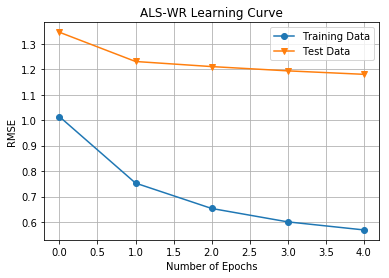

In [188]:
# Check performance by plotting train and test errors
plt.plot(range(n_epochs), train_errors, marker='o', label='Training Data');
plt.plot(range(n_epochs), test_errors, marker='v', label='Test Data');
plt.title('ALS-WR Learning Curve')
plt.xlabel('Number of Epochs');
plt.ylabel('RMSE');
plt.legend()
plt.grid()
plt.show()

### ALS predictions

In [190]:
alsPredictions = np.dot(P.T,Q)
svdPredictions = np.dot(np.dot(u, s_diag_matrix), vt)

print('SVD RMSE: ' + str(rmse(svdPredictions, uMatrixTest)))
print('ALS RMSE: ' + str(rmse(alsPredictions, uMatrixTest)))

SVD RMSE: 3.0544188095491758
ALS RMSE: 1.1799307798721266


In [191]:
queryAnswer = alsPredictions[queryUser,noWatchedMovies]
queryAnswer = noWatchedMovies[np.argsort(queryAnswer)[::-1]] #descending order

print('so, it is expected he/she also likes ... ')
print(' ')

printAnswer = queryAnswer[0:11]
for answerId in printAnswer:
    print(idx_to_title[answerId])

so, it is expected he/she also likes ... 
 
Dallas Buyers Club (2013)
Call Me by Your Name (2017)
Calendar Girl (1993)
Bottle Rocket (1996)
Victoria (2015)
Hours, The (2002)
All Watched Over by Machines of Loving Grace (2011)
All About My Mother (Todo sobre mi madre) (1999)
Love & Mercy (2014)
Three Colors: Red (Trois couleurs: Rouge) (1994)
Jackass Number Two (2006)


---
<a id='exercises'></a>
## 5. Exercises (advanced)


<div class = "alert alert-success">
<b>E1:</b> Implement centered cosine similarity metric in Section 3.2
</div>

<div class = "alert alert-success">
<b>E2:</b> Implement global baseline biased in 3.2: $b_{ui} = \mu + b_u + b_i$
</div>

<div class = "alert alert-success">
<b>E3:</b> Implement k-neighbors in 3.2
</div>